# 💻 Reklassifisering av data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GMGI221-2024/forelesninger/blob/main/09_reklassifisering.ipynb)

Reklassifisering av data basert på spesifikke kriterier er en vanlig oppgave når man utfører GIS
analyse. Formålet med denne notebooken er å se hvordan vi kan reklassifisere verdier
basert på noen kriterier. Man kunne for eksempel klassifisere informasjon basert på
reisetider og boligpriser ved hjelp av disse kriteriene:

1. Hvis reisetiden til jobben min er mindre enn 30 minutter, **OG**
2. husleien for leiligheten er mindre enn 10000 kr per måned

Hvis begge kriteriene er oppfylt: Jeg går for å se leiligheten og prøver å leie den
Hvis ikke: Jeg fortsetter å lete etter noe annet


I denne opplæringen vil vi:

1. Bruk klassifiseringsskjemaer fra PySAL [mapclassify
   bibliotek](https://pysal.org/mapclassify/) for å klassifisere befolkningstall til
   flere klasser.

2. Opprett en egendefinert klassifisering for å klassifisere og benytte den


## Inputdata

Vi vil bruke befolkningsdata fra [SSB](https://kart.ssb.no/) for Oslo, som inneholder 2380 celler for Oslo kommune.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_MAPPE = NOTEBOOK_PATH / "data"

In [2]:
import geopandas

rutenett = geopandas.read_file(DATA_MAPPE / "ssb_rutenett" / "befolkning_250m_2023_oslo.shp")

rutenett.head()

,fid,ru250m,pop_tot,geometry
0,1.0,2.263751e+13,14,"POLYGON ((264000.000 6643000.000, 263750.000 6..."
1,2.0,2.264001e+13,177,"POLYGON ((264250.000 6643000.000, 264000.000 6..."
2,3.0,2.264251e+13,169,"POLYGON ((264500.000 6643000.000, 264250.000 6..."
3,4.0,2.264501e+13,261,"POLYGON ((264750.000 6643000.000, 264500.000 6..."
4,5.0,2.264751e+13,106,"POLYGON ((265000.000 6643000.000, 264750.000 6..."


## Vanlige klassifiseringer

### Klassifiseringsskjemaer for tematiske kart

[PySAL](https://pysal.org/) -modulen er et omfattende Python-bibliotek for romlig
analyse. Det inkluderer også alle de vanligste dataklassifiseringene som er
brukt vanlig f.eks. når man visualiserer data. Tilgjengelige kartklassifiseringer i [pysal's
mapclassify -modul](https://github.com/pysal/mapclassify):

- Box Plot
- Equal Interval
- Fisher Jenks
- Fisher Jenks Sampled
- HeadTail Breaks
- Jenks Caspall
- Jenks Caspall Forced
- Jenks Caspall Sampled
- Max P Classifier
- Maximum Breaks
- Natural Breaks
- Quantiles
- Percentiles
- Std Mean
- User Defined



**NoData-verdiene presenteres med verdi -1**. 
Derfor må vi først fjerne No Data-verdiene.

In [3]:
# Inkluder bare data som er over eller lik 0
rutenett = rutenett.loc[rutenett["pop_tot"] >=0]

La oss plotte dataene og se hvordan det ser ut
- `cmap` parameter definerer fargekartet. Les mer om [valg av fargekart i matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- `scheme` alternativ skalerer fargene i henhold til et klassifiseringsskjema (krever at `mapclassify` modulen er installert):

<Axes: >

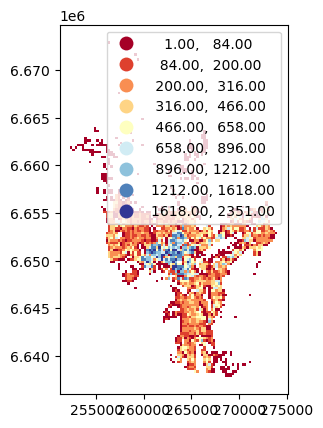

In [4]:
# Plott ved hjelp av 9 klasser og klassifiser verdiene ved hjelp av "Natural Breaks" klassifisering
rutenett.plot(column="pop_tot", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True, aspect=1)

Som vi kan se fra dette kartet, er befolkningen større i sentrum, men det er også noen områder med få beboere i
noen andre områder (hvor fargen er rød).

### Bruk av klassifiseringer på data

Som nevnt, definerer `scheme` alternativet klassifiseringsskjemaet ved hjelp av
`pysal/mapclassify`. La oss se nærmere på hvordan disse klassifiseringene fungerer.

In [5]:
import mapclassify

#### Natural Breaks

In [6]:
mapclassify.NaturalBreaks(y=rutenett["pop_tot"], k=9)

NaturalBreaks

     Interval        Count
--------------------------
[   1.00,   84.00] |   680
(  84.00,  200.00] |   461
( 200.00,  315.00] |   512
( 315.00,  462.00] |   284
( 462.00,  658.00] |   181
( 658.00,  896.00] |    98
( 896.00, 1212.00] |    81
(1212.00, 1618.00] |    58
(1618.00, 2351.00] |    25

#### Quantiles (standard er 5 klasser):

In [7]:
mapclassify.Quantiles(y=rutenett["pop_tot"])

Quantiles

     Interval        Count
--------------------------
[   1.00,   31.00] |   480
(  31.00,  160.00] |   476
( 160.00,  262.00] |   476
( 262.00,  433.20] |   472
( 433.20, 2351.00] |   476

#### Trekk ut terskelverdiene

Det er mulig å trekke ut terskelverdiene i en matrise:

In [8]:
klassifiserer = mapclassify.NaturalBreaks(y=rutenett["pop_tot"], k=9)
klassifiserer.bins

array([  83.,  198.,  315.,  462.,  658.,  896., 1212., 1618., 2351.])

La oss bruke en av `Pysal` klassifiseringene på dataene våre og klassifisere
befolkningen til 9 klasser
Klassifiseringen må først initialiseres med `make()` funksjonen som tar
antall ønskede klasser som inngangsparameter

In [9]:
# Lag en Natural Breaks klassifisering
klassifiserer = mapclassify.NaturalBreaks.make(k=9)

- Nå kan vi bruke klassifiseringen på dataene våre ved å bruke `apply` -funksjonen

In [10]:
# Klassifiser dataene
klassifiseringer = rutenett[["pop_tot"]].apply(klassifiserer)

# La oss se hva vi har
klassifiseringer.head()

,pop_tot
0,0
1,1
2,1
3,2
4,1


In [11]:
type(klassifiseringer)

pandas.core.frame.DataFrame

Ok, så nå har vi en DataFrame der inngangskolonnen vår ble klassifisert til 9
forskjellige klasser (tallene 1-9) basert på [Natural Breaks
klassifisering](http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Jenks_Natural_Breaks_Classification).

Vi kan også legge til klassifiseringsverdiene direkte i en ny kolonne i vår dataframe:

In [12]:
# Gi nytt navn til kolonnen så vi vet at den ble klassifisert med naturlige brudd
rutenett["nb_pop_tot"] = rutenett[["pop_tot"]].apply(klassifiserer)

# Sjekk de opprinnelige verdiene og klassifiseringen
rutenett[["pop_tot", "nb_pop_tot"]].head()

,pop_tot,nb_pop_tot
0,14,0
1,177,1
2,169,1
3,261,2
4,106,1


Flott, nå har vi disse verdiene i GeoDataFramen. La oss
visualisere resultatene og se hvordan de ser ut.

<Axes: >

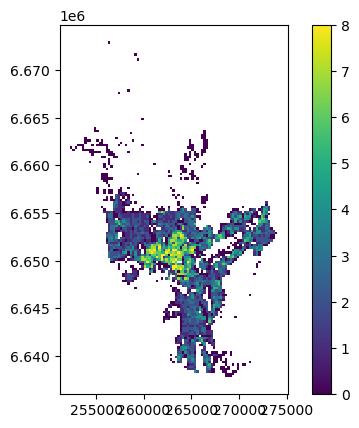

In [13]:
# Plott
rutenett.plot(column="nb_pop_tot", linewidth=0, legend=True)

Og her går vi, nå har vi et kart der vi har brukt en av de vanlige
klassifiseringene for å klassifisere dataene våre i 9 klasser.


## Plott et histogram

Et histogram er en grafisk representasjon av datafordelingen. Når
man klassifiserer data, er det alltid bra å vurdere hvordan dataene er fordelt,
og hvordan klassifiseringsskjemaet deler verdier i forskjellige områder.

- plott histogrammet ved hjelp av [pandas.DataFrame.plot.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html)
- Antall histogrambinner (grupper av data) kan kontrolleres ved hjelp av parameteren `bins`:

<Axes: ylabel='Frequency'>

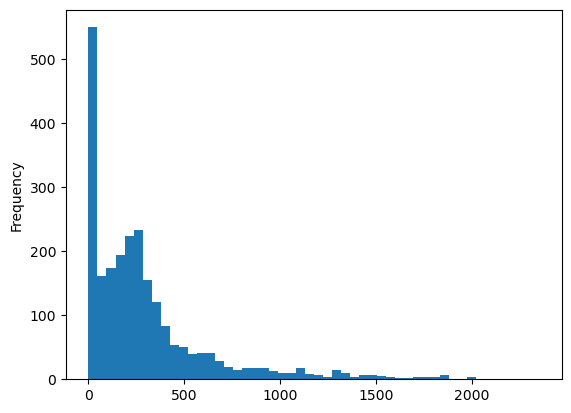

In [14]:
# Histogram for befolkningsrutenettet
rutenett["pop_tot"].plot.hist(bins=50)

La oss også legge til terskelverdier på toppen av histogrammet som vertikale linjer.

- Natural Breaks:

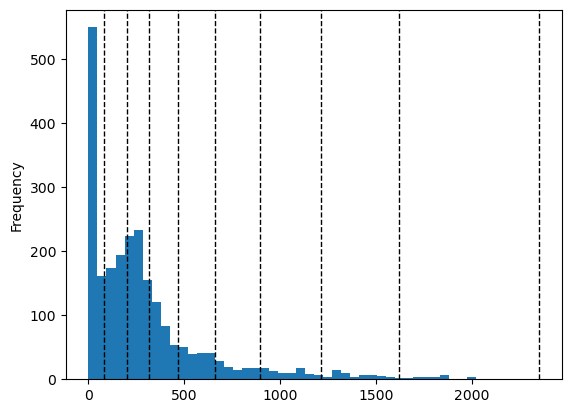

In [15]:
import matplotlib.pyplot as plt

# Definer klassifiserer
klassifiserer = mapclassify.NaturalBreaks(y=rutenett["pop_tot"], k=9)

# Plott histogram for befolkningsrutenettet
rutenett["pop_tot"].plot.hist(bins=50)

# Legg til vertikale linjer for klassebrudd
for break_point in klassifiserer.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

- Kvartiler:

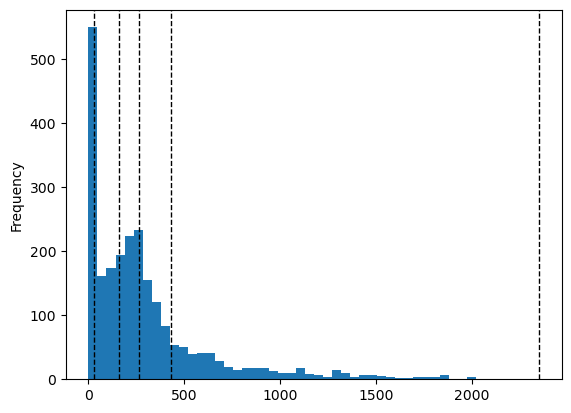

In [16]:
# Definer klassifiserer
klassifiserer = mapclassify.Quantiles(y=rutenett['pop_tot'])

# Plott histogram for befolkningsrutenettet
rutenett["pop_tot"].plot.hist(bins=50)

for break_point in klassifiserer.bins:
    plt.axvline(break_point, color="k", linestyle="dashed", linewidth=1)

## Bruke en egendefinert klassifisering

### Multikriterium dataklassifisering

La oss klassifisere geometriene i to klasser basert
på en gitt `terskel` -parameter. Hvis området til en polygon er lavere enn terskelverdien, vil utgangskolonnen få en verdi
0, hvis den er større, vil den få en verdi 1. Denne typen klassifisering kalles ofte en [binær
klassifisering](https://en.wikipedia.org/wiki/Binary_classification).

For å klassifisere hver rad i vår GeoDataFrame kan vi iterere over hver rad, eller vi kan bruke
en funksjon for hver rad. I vårt tilfelle vil vi bruke en lambda funksjon for hver rad i
vår GeoDataFrame, som returnerer en verdi basert på de vilkårene vi gir.

La oss klassifisere basert på to kriterier: og finne ut rutenettceller

1. Rutenettceller der befolkningen er **mindre eller lik 50** 

2. *og* Rutenettceller der befolkningen er **større eller lik 15** 

La oss først se hvordan vi klassifiserer en enkelt rad:

In [17]:
rutenett.iloc[0]["pop_tot"] <= 50 and rutenett.iloc[0]["pop_tot"] > 15

False

In [18]:
int(rutenett.iloc[2000]["pop_tot"] < 50 and rutenett.iloc[2000]["pop_tot"] > 15)

0

La oss nå bruke dette på vår GeoDataFrame og lagre det i en kolonne kalt `"suitable_area"`:

In [19]:
rutenett["egnet"] = rutenett.apply(lambda row: int(row["pop_tot"] < 50 and row["pop_tot"] > 15), axis=1)

In [20]:
rutenett.head()

,fid,ru250m,pop_tot,geometry,nb_pop_tot,egnet
0,1.0,2.263751e+13,14,"POLYGON ((264000.000 6643000.000, 263750.000 6...",0,0
1,2.0,2.264001e+13,177,"POLYGON ((264250.000 6643000.000, 264000.000 6...",1,0
2,3.0,2.264251e+13,169,"POLYGON ((264500.000 6643000.000, 264250.000 6...",1,0
3,4.0,2.264501e+13,261,"POLYGON ((264750.000 6643000.000, 264500.000 6...",2,0
4,5.0,2.264751e+13,106,"POLYGON ((265000.000 6643000.000, 264750.000 6...",1,0


Ok, vi har nye verdier i `egnet` -kolonnen.

- Hvor mange polygoner passer for oss? La oss finne ut ved hjelp av en Pandas
  funksjon kalt `value_counts()` som returnerer antall forskjellige verdier i
  vår kolonne.

In [21]:
# Få antall verdier
rutenett["egnet"].value_counts()

egnet
0    2216
1     164
Name: count, dtype: int64

Ok, så det ser ut til å være 164 passende steder.

- La oss se hvor de er lokalisert:

<Axes: >

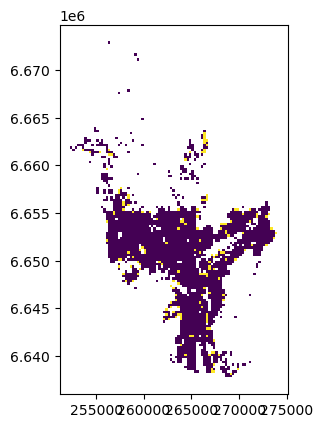

In [22]:
# Plott
rutenett.plot(column="egnet", linewidth=0)